Learning All laws on a 1D grid
============================
Using Wolfram's 256 rules of Cellular Automata

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf

2022-01-27 14:06:58.024900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 14:06:58.024961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Constant motion  
(replaced by Wolfram's rules since it is one of them, namely eg. Rule 170 moving to the left)

In [2]:
L=10 #length of 1-d box

def cm_update(x):
    L=len(x)
    y=x.copy()
    for i in range(L):
        y[i]=x[(i-1)%L]
    return(y)


## Wolfram's 256 Rules

These are all cellular automaton rules for a 1-d array with only neares neighbour interaction. There are therefore only three cells (L,C,R) determining the outcome of one cell (C). This gives 2^3=8 possible combinations that can give rise to an outcome of 2 possibilities. Thus there are 2^8=256 possible rules. 

The following function generates each of these rules.
 
Input:  
num = number of rule  
inp = string of input bits   
t = number of timesteps calculated  

Output: an array of arrays each for one timestep beginning with the input array. 

The boudary conditions are periodic
        

In [3]:
def CellularAutomata(num,inp,t):
    bnum = np.flip(np.fromiter(np.binary_repr(num,width=8),dtype=int))
    out = [np.fromiter(inp,dtype=int)]
    lin = len(inp)
    currinp = inp
    for n in range(t):
        outnow = []
        for i in range(len(inp)):
            outnow = np.append(outnow,bnum[int(str(currinp[(i-1)%lin])+str(currinp[(i)%lin])+str(currinp[(i+1)%lin]),2)])

        currinp =''.join([str(int(elem)) for elem in outnow])
        out = np.append(out,[outnow],axis=0)
    return(out)


## Generating Data

In [302]:
N=1000 #batch size
L=100 #Length of box
rule= 10
time = 1

x_train=[]
y_train=[]


for i in range(N):
    #x=[0,0,0]
    #x[np.random.randint(0,3)]=1
    x=np.random.randint(0,2,L)
    x_train.append(np.copy(x))
    y_train.append(np.copy(CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time]))
    #print(''.join([str(int(elem)) for elem in x]),CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time,0])

#for i in range(20):
 #   print(x_train[i],y_train[i])
    
x_train = np.array(x_train).reshape(N,L,1)
y_train = np.array(y_train).reshape(N,L)
print(x_train.shape,y_train.shape)

(1000, 100, 1) (1000, 100)


In [203]:
#Counting the number of occurence of certain elements
#must be done before reshape (will error usually, unomment the reshape above)
count=0
for x in x_train:
  #  if all(x == [0,0,1]) or all(x == [0,0,0]) or all(x == [1,0,0]) or all(x == [1,1,0]) or all(x == [1,1,1]):
    if all(x == [0,0,0,0,0,0,0]):
         
        count+=1
print(count/N)

0.0073


## Models
useful resource for understanding what is going on:  
Padding https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
Guide to 2d conv layers https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
Guide to 1d conv layers https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/  
shapes, dimensions and units https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc  


### Dense layers

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(L,activation="softmax")
])

### 1-D Convolutional layer

In [221]:
#Periodic padding (not currently in use)
def periodic_padding_flexible(tensor, axis,padding=1):
    """
        add periodic padding to a tensor for specified axis
        tensor: input tensor
        axis: on or multiple axis to pad along, int or tuple
        padding: number of cells to pad, int or tuple

        return: padded tensor
    """


    if isinstance(axis,int):
        axis = (axis,)
    if isinstance(padding,int):
        padding = (padding,)

    ndim = len(tensor.shape)
    for ax,p in zip(axis,padding):
        # create a slice object that selects everything from all axes,
        # except only 0:p for the specified for right, and -p: for left

        ind_right = [slice(-p,None) if i == ax else slice(None) for i in range(ndim)]
        ind_left = [slice(0, p) if i == ax else slice(None) for i in range(ndim)]
        right = tensor[ind_right]
        left = tensor[ind_left]
        middle = tensor
        tensor = tf.concat([right,middle,left], axis=ax)

    return tensor

In [222]:
## defining the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(100, 3, activation='relu', input_shape=(L,1),padding='valid'))
model.add(tf.keras.layers.Conv1D(100, 1, activation='relu', input_shape=(L,1),padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(L,activation="softmax"))


In [250]:
t1 = [[1, 2, 3,4, 5, 6]]
t2 = [[7, 8, 9,10, 11, 12]]
tf.concat([t1, t2], 1)


<tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]], dtype=int32)>

In [303]:
#add periodic padding
def periodic_padding(imbatch, padding=1):
    '''
    Create a periodic padding (wrap) around an image batch, to emulate 
    periodic boundary conditions. Padding occurs along the middle two axes
    '''
    pad_u = imbatch[:, -padding:, :]
    pad_b = imbatch[:, :padding, :]

    partial_image = tf.concat([pad_u, imbatch, pad_b], axis=1)

#    pad_l = partial_image[..., -padding:, :]
 #   pad_r = partial_image[..., :padding, :]

 #   padded_imbatch = tf.concat([pad_l, partial_image, pad_r], axis=2)
          
    
    return padded_imbatch

class Wraparound2D(tf.keras.layers.Layer):
    """
    Apply periodic boundary conditions on an image by padding 
    along the axes
    padding : int or tuple, the amount to wrap around    
    """

    def __init__(self, padding=2, **kwargs):
        super(Wraparound2D, self).__init__()
        self.padding = padding

In [307]:
## (Approx) Model from Paper https://arxiv.org/pdf/1809.02942.pdf
nhood = 1
shape = (1,L)
wspan,hspan = shape
diameter = 3
layer_dims=[10,8,8]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer((hspan,1))) 
model.add(Wraparound2D(padding=nhood)) #adding periodic padding extending by nhood
model.add(tf.keras.layers.Conv1D(
        layer_dims[0],
        diameter,
        activation='softmax', 
        input_shape=(hspan,1),
        padding='same',
        kernel_initializer=tf.keras.initializers.he_normal(),
        bias_initializer=tf.keras.initializers.he_normal()                                
        )      
    )
for i in range(1,len(layer_dims)):      
    model.add(tf.keras.layers.Conv1D(layer_dims[i],1, activation='softmax', input_shape=(hspan,1),padding='same'))
    #model.add(tf.keras.layers.Dense(layer_dims[i], activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(L,activation="softmax"))
model.summary()


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wraparound2d_28 (Wraparound2 (None, 100, 1)            0         
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 100, 10)           40        
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 100, 8)            88        
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 100, 8)            72        
_________________________________________________________________
flatten_67 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 100)               80100     
Total params: 80,300
Trainable params: 80,300
Non-trainable params: 0
_________________________________________________

### Executing the learning

Epoch 1/50
32/32 [==============================] - 1s 4ms/step - loss: 146.9821 - binary_accuracy: 0.7504
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 210.0123 - binary_accuracy: 0.7504
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 260.6347 - binary_accuracy: 0.7504
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 288.5434 - binary_accuracy: 0.7504
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 291.6289 - binary_accuracy: 0.7504
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 277.9780 - binary_accuracy: 0.7504
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 280.5459 - binary_accuracy: 0.7504
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 288.7932 - binary_accuracy: 0.7504
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 262.0695 - binary_accuracy: 0.7504
Epoch 10/50
32/32 [==================

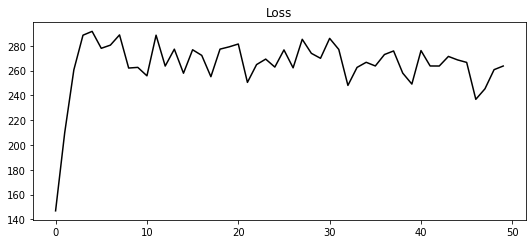

In [308]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
#loss_fn = tf.keras.metrics.BinaryAccuracy()
#loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="auto",name="sparse_categorical_crossentropy")


predictions = model(x_train).numpy()

loss_fn(y_train, predictions).numpy()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=loss_fn,
              metrics=[tf.keras.metrics.BinaryAccuracy()]
                #metrics= [tf.keras.losses.CategoricalCrossentropy()]
             )
train_history = model.fit(x=x_train, y=y_train, epochs=50,verbose=1)
plt.title("Loss")
plt.plot(train_history.history['loss'], 'k')

Input:    [1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0
 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1]
Model prd: [2.05790661e-02 8.20735295e-05 2.69371696e-04 1.48805594e-02
 2.22479552e-03 5.82162244e-03 1.51331434e-07 1.72152141e-07
 7.39303505e-05 2.23350315e-03 1.86897296e-06 3.53391515e-04
 2.06503610e-05 2.80691753e-03 2.46984954e-03 1.85707177e-03
 3.20825318e-04 3.15188045e-05 2.23820377e-02 3.91524174e-11
 7.23589401e-05 8.77813545e-06 2.21146751e-04 2.43010646e-07
 1.76804460e-05 3.09834760e-02 3.77911806e-06 3.86931461e-05
 4.76185527e-08 1.49826305e-02 7.69682262e-10 2.32789944e-07
 2.51856283e-03 3.48200629e-05 1.08021274e-02 1.31468400e-01
 1.35215417e-09 1.25147199e-04 2.01993666e-09 1.80279294e-12
 9.89472494e-02 4.51247357e-02 5.99608114e-08 3.28112917e-04
 7.75014749e-03 6.58245819e-11 1.37499478e-08 1.15568139e-01
 1.05250217e-06 5.77068003e-03 6.52140884e-

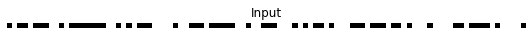

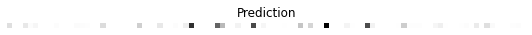

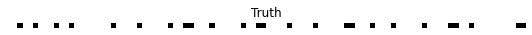

In [309]:
num=100

print("Input:   ",np.array(x_train).reshape(N,L)[num])
print("Model prd:",model(x_train)[num].numpy())
print("ytrain:   ",y_train[num])



from matplotlib import pyplot as plt

arr_x = np.array([np.array(x_train).reshape(N,L)[num]])
arr_model = np.array([model(x_train)[num].numpy()])
arr_y = np.array([y_train[num]])


color_map = plt.cm.get_cmap('gray')
plt.axis('off')
plt.title("Input")
plt.imshow(arr_x,cmap=color_map.reversed())
plt.show()
plt.axis('off')
plt.title("Prediction")
plt.imshow(arr_model,cmap=color_map.reversed())
plt.show()
plt.axis('off')
plt.title("Truth")
plt.imshow(arr_y,cmap=color_map.reversed())
plt.show()

Somehow my model only seems to predict zeroes and thus gets an accuracy equal to the average number of zeros :/